Import libraries. 
If you do not have a library installed use this tutorial: https://packaging.python.org/en/latest/tutorials/installing-packages/ to install them

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

Use this cell to personalize file names and locations

In [4]:
data_file_location = 'data/processed_data.tsv'
json_location = '../genes.json'
fig_1_destination = 'figures/'
fig_1_file_name = 'figure_1.png'

Import data and calculate the sorting order based on percent 80th percentile or above

In [5]:
data = pd.read_csv(data_file_location, sep='\t', index_col=0)
with open(json_location, 'r') as file:
    marker_genes = json.load(file)

columns = list(marker_genes.keys()) + ['overall_score']

# Calculate median values for each cancer type
median_values = {}
percentile_80 = {}

for column in columns:
    median_values[column] = data.groupby("project_id")[column].median()
    percentile_80[column] = median_values[column].quantile(0.8)


# Sort cancer types by median total score to get top 5
median_overall_sorted = median_values['overall_score'].sort_values(ascending=True)
top_cancer_types = median_overall_sorted[median_overall_sorted > percentile_80['overall_score']]


Create plot

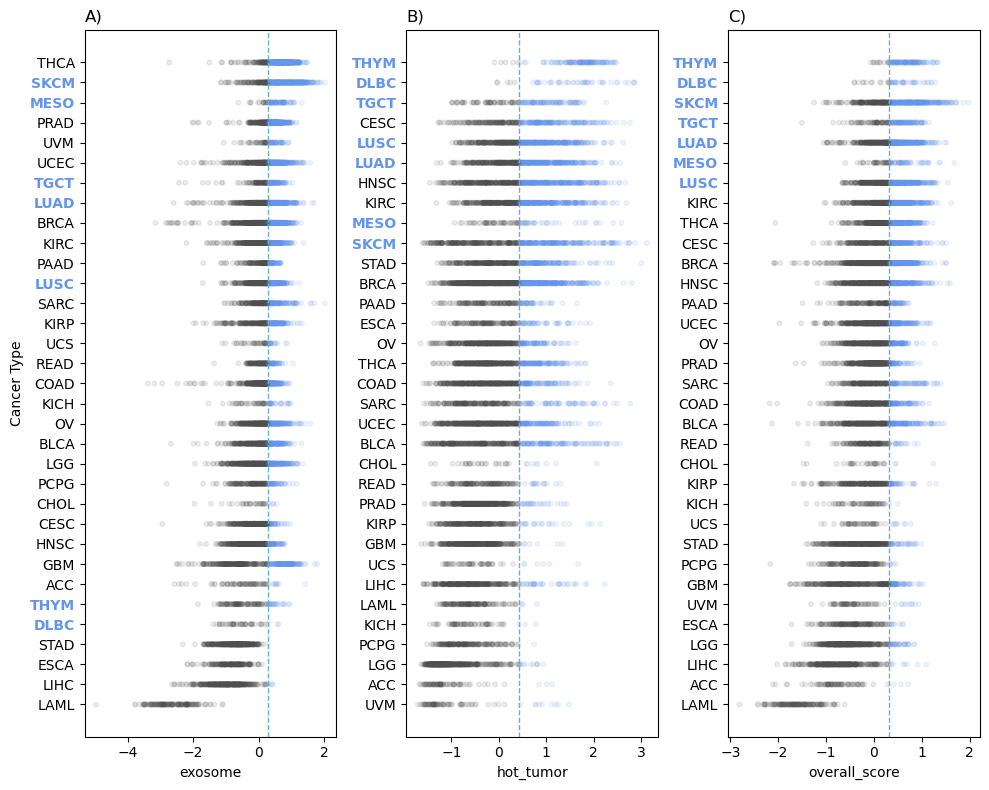

In [6]:
# Function to highlight the same top 5 cancer types across all plots
def highlight_labels(ax):
    labels = ax.get_yticklabels()
    for label in labels:
        if label.get_text() in top_cancer_types:
            label.set_color('cornflowerblue')
            label.set_fontweight('bold')

# Create the figure with 4 subplots
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(10, 8))

# Function to plot scatter plots
def plot_scatter(ax, data_col, median_values, percentile_80, xlabel):
    # Sort by median values for individual plot
    sorted_cancer_types = median_values.sort_values(ascending=True).index
    data_sorted = data.set_index("project_id").loc[sorted_cancer_types]
    
    # Highlight points 80th percentile and above
    data_sorted["color"] = np.where(data_sorted[data_col] >= percentile_80, "cornflowerblue", "#4f4f4f")
    # plot points and 80th percentile line
    ax.scatter(data_sorted[data_col], data_sorted.index, c=data_sorted["color"], s=11, alpha=0.1)
    ax.axvline(x=percentile_80, color="#6baed6", linestyle="--", linewidth=1, label="80th Percentile")
    ax.set_xlabel(xlabel)
    ax.set_yticks(range(len(sorted_cancer_types)))
    ax.set_yticklabels(sorted_cancer_types)
    highlight_labels(ax)


for i, col in enumerate(columns):
    plot_scatter(axes[i], col, median_values[col], percentile_80[col], col)
    if i == 0:
        axes[i].set_ylabel('Cancer Type')
    axes[i].set_title(f'{chr(65 + i)})', loc='left')

# Adjust layout
plt.tight_layout()
plt.savefig(fig_1_destination + fig_1_file_name)
plt.show()